In [1]:
from src.data_gen import data_gen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
np.random.seed(0)
df = data_gen(T0=20, T1=10, N_co=45, N_tr=5, L=10, K=5, drift=2)

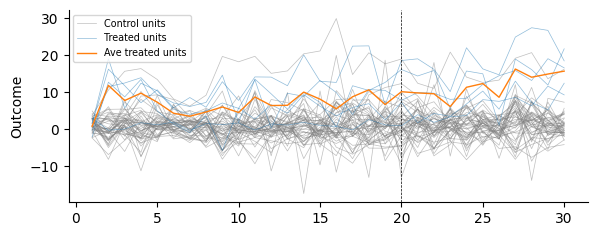

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 2.5))

pivot_co = df.query("tr_group==0").pivot(index='id', columns='year', values='y')
# Plot for control group with a specific color
for i in pivot_co.index:
    sns.lineplot(data=pivot_co.loc[i], legend=False, ax=ax, color=color[7], linewidth=0.5, alpha=0.5, label='Control units' if i==pivot_co.index[0] else None)

pivot_tr = df.query("tr_group==1").pivot(index='id', columns='year', values='y')
# Plot for treatment group with a specific color
for i in pivot_tr.index:
    sns.lineplot(data=pivot_tr.loc[i], legend=False, ax=ax, color=color[0], linewidth=0.5, alpha=0.5, label='Treated units' if i==pivot_tr.index[0] else None)

# one year before the treatment
ax.axvline(df.query("post_period==0").year.max(), color='black', linestyle='--', linewidth=0.5)

# average for treated group
sns.lineplot(data=df.query("tr_group==1").groupby('year').y.mean(), legend=False, ax=ax, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
ax.legend(fontsize='x-small')
ax.set(xlabel='', ylabel='Outcome')
sns.despine()
plt.savefig('figs/panel_data.png', dpi=300, bbox_inches='tight')

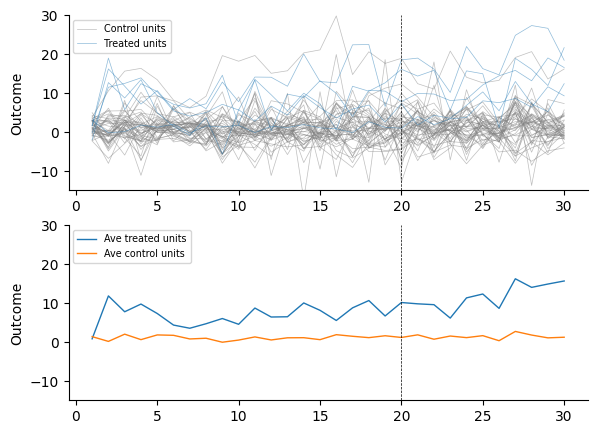

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

pivot_co = df.query("tr_group==0").pivot(index='id', columns='year', values='y')
# Plot for control group with a specific color
for i in pivot_co.index:
    sns.lineplot(data=pivot_co.loc[i], legend=False, ax=ax1, color=color[7], linewidth=0.5, alpha=0.5, label='Control units' if i==pivot_co.index[0] else None)

pivot_tr = df.query("tr_group==1").pivot(index='id', columns='year', values='y')
# Plot for treatment group with a specific color
for i in pivot_tr.index:
    sns.lineplot(data=pivot_tr.loc[i], legend=False, ax=ax1, color=color[0], linewidth=0.5, alpha=0.5, label='Treated units' if i==pivot_tr.index[0] else None)

# one year before the treatment
ax1.axvline(df.query("post_period==0").year.max(), color='black', linestyle='--', linewidth=0.5)

ax1.legend(fontsize='x-small')
ax1.set(xlabel='', ylabel='Outcome', ylim=(-15, 30))

sns.lineplot(data=df.query("tr_group==1").groupby('year').y.mean(), legend=False, ax=ax2, color=color[0], linestyle='-', linewidth=1, label='Ave treated units')
sns.lineplot(data=df.query("tr_group==0").groupby('year').y.mean(), legend=False, ax=ax2, color=color[1], linestyle='-', linewidth=1, label='Ave control units')
ax2.axvline(df.query("post_period==0").year.max(), color='black', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize='x-small')
ax2.set(xlabel='', ylabel='Outcome', ylim=(-15, 30))

sns.despine()